# Response Estimation

In [20]:
# Fix RC overwriting
%config InlineBackend.rc = {}

from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
from mplhep.styles import ROOT
from scipy.fft import irfft, rfft
from scipy.optimize import minimize_scalar
from texat.signal.waveforms import gaussian

plt.style.use(ROOT)
plt.rc("figure", figsize=(10, 5), dpi=120)

data_path = Path("data")

Channels which employ the AGET shaper require deconvolution in order to recover the underlying signal. This process requires a good knowledge of the underlying response function of the system. An approximate analytical solution is given in {cite:ps}`giovinazzo_get_2016`:
:::{math}
:label: get-response

h(t) = A \cdot \exp \left(-3 \frac{t}{\tau}\right) \cdot\left(\frac{t}{\tau}\right)^{3} \cdot \sin \left(\frac{t}{\tau}\right)\,,\\
:::
for {math}`\tau=\frac{\tau_s}{\delta t}`, where {math}`\tau` is the shaping time and {math}`\delta t` the reciprocal sampling rate. The authors note, however, that it is insufficiently accurate to be used with deconvolutional methods. Whilst the electronics can be configured such that the response function can be directly measured, this would have required further access to the detector which resides at the Cyclotron Institute, Texas A&M University.{cite:ps}`giovinazzo_get_2016` Without the ability to experimentally derive a response function, an estimate was determined through two separate methods.

:::{admonition} To Do

Show visual example of convolution
:::

## Iterative Estimation
In order to determine a better approximation for the response function, an iterative deconvolve-fit process can be applied to a set of MicroMeGaS waveforms. These waveforms should be taken from a random spanning sample of the recorded MicroMeGaS waveforms (see {numref}`mm-random-sample`). 

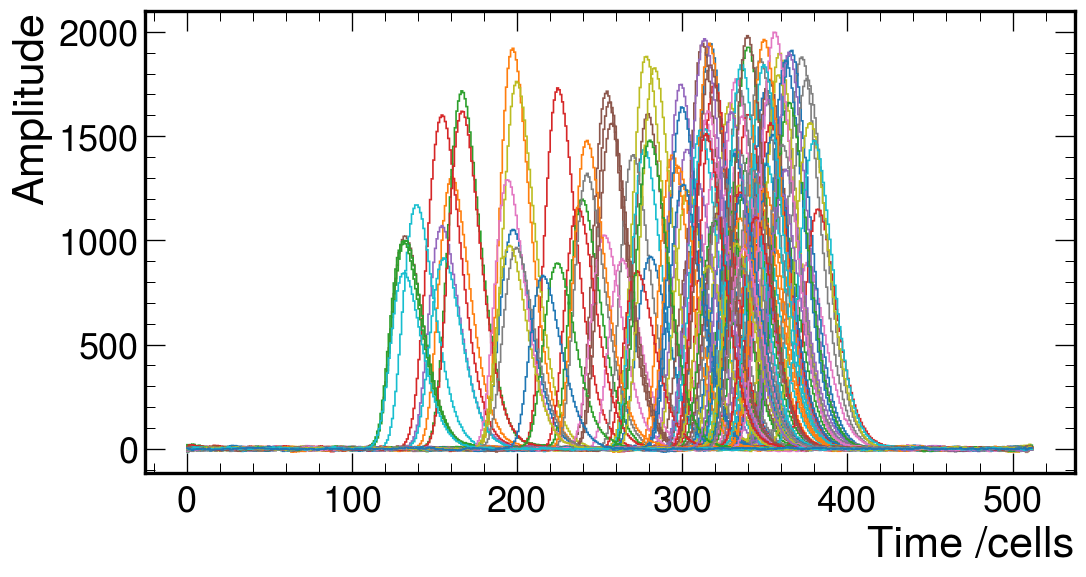

In [21]:
sample_mm = np.load(data_path / "sample-mm.npy")

plt.figure()
for s in sample_mm:
    plt.stairs(s)
plt.xlabel("Time /cells")
plt.ylabel("Amplitude");

Given such a sample, an initial estimate of the response function $F^{(1)}$ can be used to fit each waveform with the convolution of a Gaussian function:

:::{math}
:label: iterative-estimate
Y^{(1)} = F^{(1)} * \mathcal{N}^{(1)}\,.
:::

{math}`F^{(1)}` can be determined from {eq}`get-response` with {math}`\tau = 502\,\text{ns}`.{cite:ps}`giovinazzo_get_2016`

The resulting fit $\mathcal{N}^{(1)}$ can then be _deconvolved_ from the original sample $Y$ to yield $F^{(2)}$. This process can be repeated until the solution becomes stable, and the solutions for a set of random waveforms may be averaged to produce a singular response function $F$ (see {numref}`mm-response-evolution`).

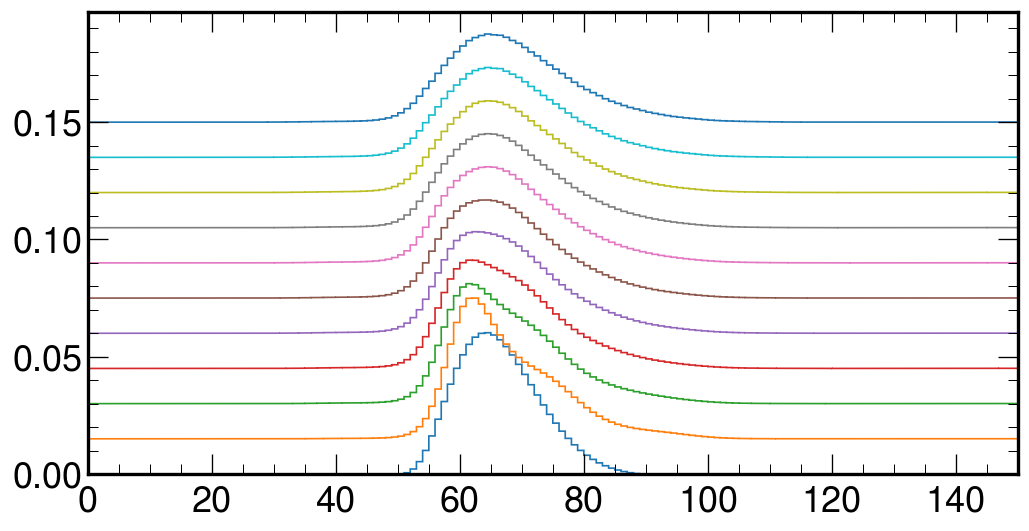

In [29]:
response = np.load(data_path / "response-evolution.npy")

for j, r_j in enumerate(response):
    if j % 5:
        continue
    plt.stairs(np.roll(r_j, 64) + j * 0.003)
plt.xlim(0, 1_50);

It can be seen that the initial function {math}`F^{(1)}` is a poor fit with respect to the final response function (shown at the top of {numref}`mm-response-evolution`). This initial fit can be improved by first optimsing the parameter $\tau$ using a convolution fit (see {numref}`mm-response-tau`):

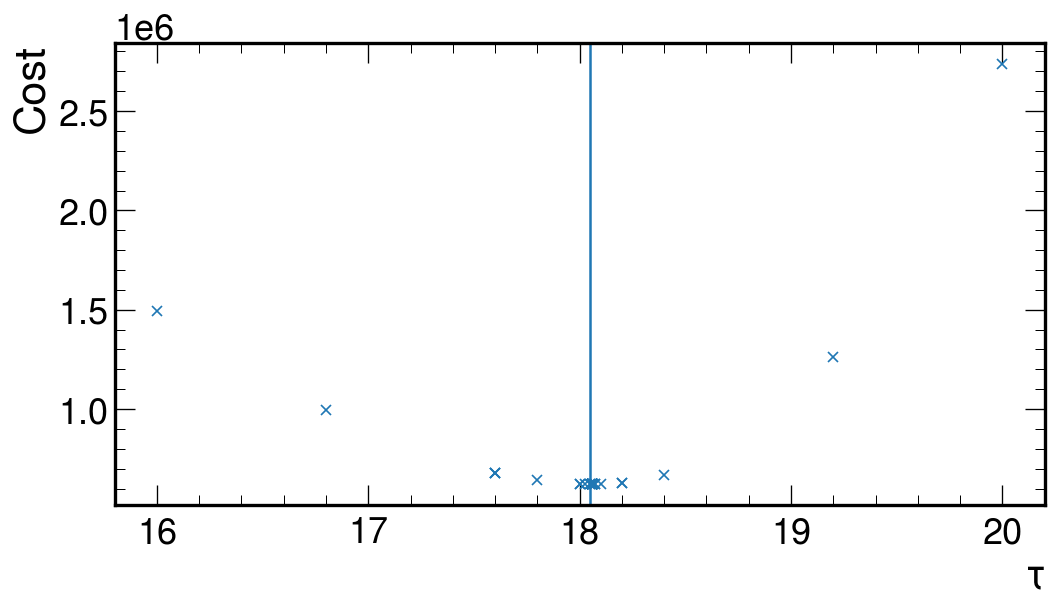

In [35]:
fit_cost = np.load(data_path / "fit-cost.npy")

plt.axvline(18.05)
plt.plot(fit_cost[:, 0], fit_cost[:, 1], "x")
plt.xlabel("$\\tau$")
plt.ylabel("Cost");

That the initial estimate for {math}`\tau` does not agree with that found by the fit shown in {numref}`mm-response-tau` is not necessarily surprising. Given that the convolution of any two Gaussians is also Gaussian, the solution from {eq}`iterative-estimate` is not guaranteed to be unique, i.e. the resulting response function may include some Gaussian component. This can be seen when the estimated MicroMeGaS response function is compared with any one silicon sample: the silicon sample is on average slightly narrower than that of the estimated response function. Applying a convolution to the silicon response function with a fixed-with Gaussian brings the two estimates into closer agreement, supporting this hypothesis (see {numref}`mm-vs-si-response`).

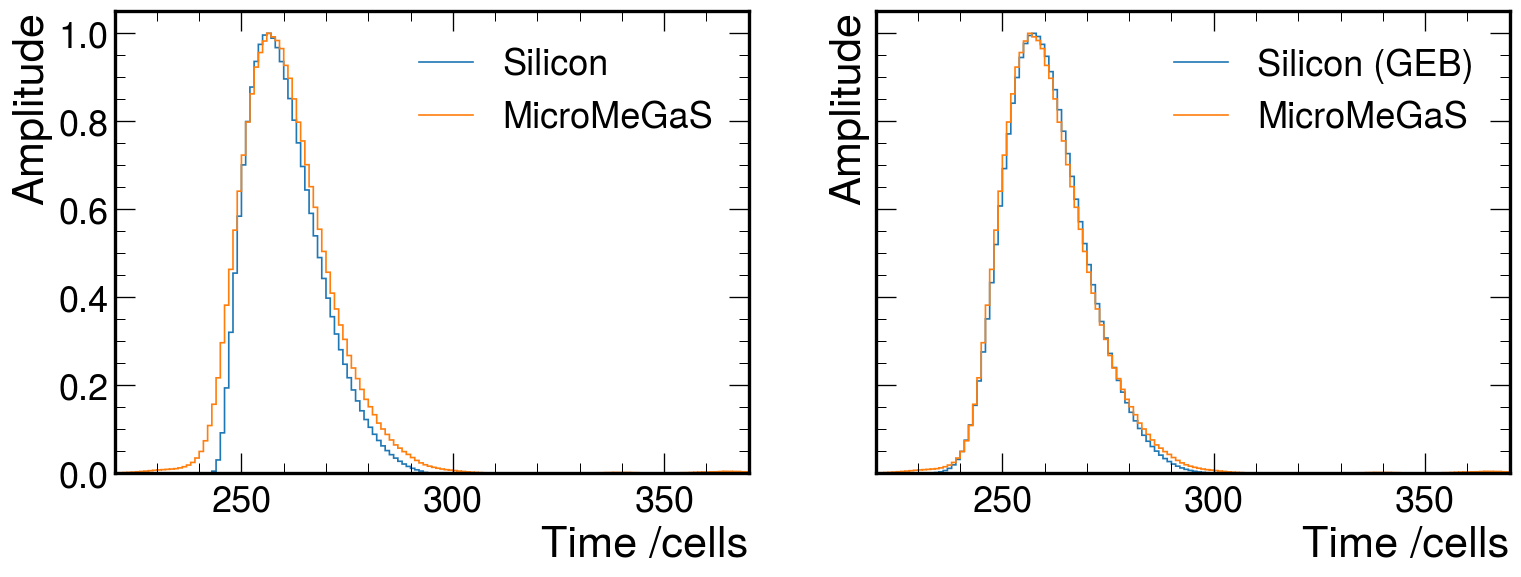

In [25]:
response_si = (response_si := np.load(data_path / "response-si.npy")) / np.max(
    response_si
)
response_mm = (response_mm := np.load(data_path / "response-mm.npy")) / np.max(
    response_mm
)


def kernel(n, sigma):
    t = np.arange(n)
    g = np.roll(gaussian(t, 1, n // 2, sigma), -n // 2)
    return g / np.sum(g)


def broaden(r, sigma):
    y = kernel(r.size, sigma)
    u = irfft(rfft(r) * rfft(y))
    return u * np.max(r) / np.max(u)


def cost(sigma):
    return np.sum((broaden(response_si, sigma) - response_mm) ** 2)


fit = minimize_scalar(cost)

response_si_broad = broaden(response_si, fit.x)
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax[0].stairs(np.roll(response_si, 256), label="Silicon")
ax[0].stairs(np.roll(response_mm, 256), label="MicroMeGaS")
ax[0].set_xlabel("Time /cells")
ax[0].set_xlim(220, 370)
ax[0].set_ylabel("Amplitude")
ax[0].legend(loc="upper right")
ax[1].stairs(np.roll(response_si_broad, 256), label="Silicon (GEB)")
ax[1].stairs(np.roll(response_mm, 256), label="MicroMeGaS")
ax[1].set_xlabel("Time /cells")
ax[1].set_xlim(220, 370)
ax[1].set_ylabel("Amplitude")
ax[1].legend(loc="upper right");

## Sample Averaging

It follows that the silicon waveforms may provide a more robust mechanism for estimating the response function. If one assumes that that the shape of the current signal produced by interactions with the silicon detector is predominantly determined by the shaper, then the measured signal is to first approximation simply a convolution of the intrinsic response function and some normal component {math}`F' * \mathcal{N}`. 

To build a response function estimate, a random sample of silicon waveforms spanning a range of amplitudes is taken. The binwise mean of this set of waveforms is taken to produce an average waveform (see {numref}`si-response-average`). This waveform is an approximate response function, which can then be time-shifted such that the peak coincides with {math}`t=0`.

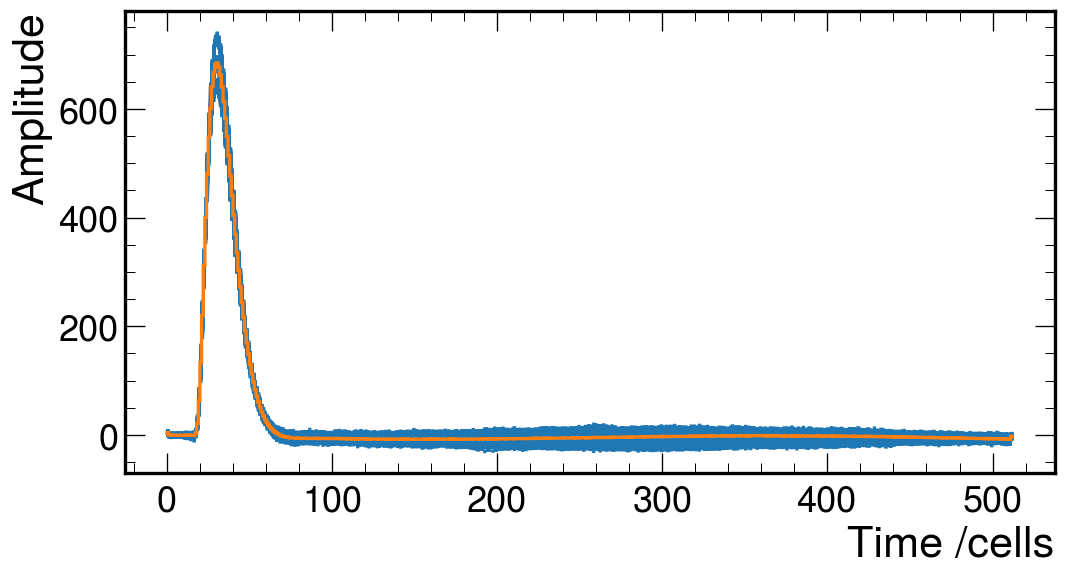

In [23]:
sample = np.load(data_path / "sample-si.npy")

fig, ax = plt.subplots()
for s in sample:
    ax.stairs(s, color="C0")
ax.set_xlabel("Time /cells")
ax.set_ylabel("Amplitude")
ax.stairs(sample.mean(axis=0))
ax.stairs(sample.mean(axis=0), linewidth=2);